In [1]:
%cd ..
%cd .. 
%cd data

/Users/azel/github/Data-Science/jupyter_notebooks
/Users/azel/github/Data-Science
/Users/azel/github/Data-Science/data


In [193]:
from fin_data import DailyTimeSeries
import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import ModelCheckpoint 

    
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [175]:
apple = DailyTimeSeries('AAPL')
df = apple.initiate()
df.head()

################################################################### 
 Ticker:  AAPL 
 Last Refreshed:  2019-09-03 
 Data Retrieved:  Daily Time Series with Splits and Dividend Events 
 ###################################################################


,AAPL_open,AAPL_high,AAPL_low,AAPL_close,AAPL_adjusted_close,AAPL_volume,AAPL_dividend_amount
date,,,,,,,
1999-09-07,73.750,77.938,73.500,76.375,2.3805,246198400.0,0.0
1999-09-08,76.188,77.688,74.500,74.500,2.3220,190551200.0,0.0
1999-09-09,75.500,75.938,73.875,75.563,2.3552,133520800.0,0.0
1999-09-10,76.000,77.688,74.688,77.438,2.4136,114690800.0,0.0
1999-09-13,77.063,77.063,74.813,75.000,2.3376,63000000.0,0.0


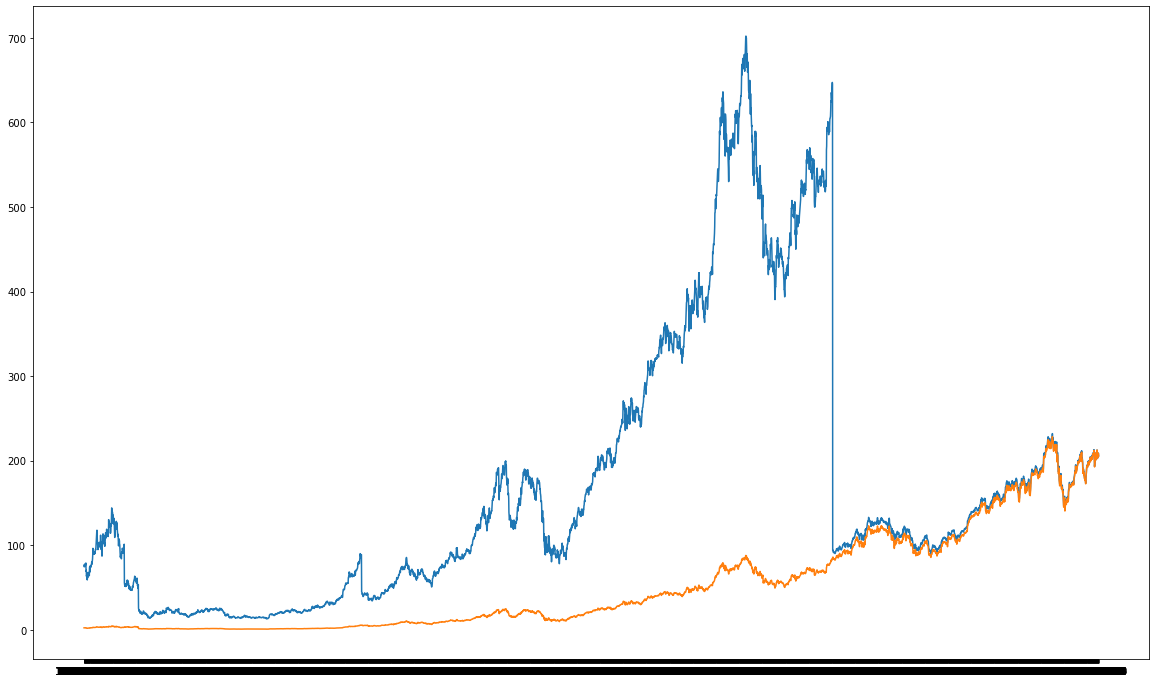

In [176]:
plt.figure(figsize=(20,12))

plt.plot(df['AAPL_close'])
plt.plot(df['AAPL_adjusted_close']);

In [177]:
df['target'] = df['AAPL_adjusted_close'].shift(-1)
#                          df['AAPL_adjusted_close']) / 
#                         (df['AAPL_adjusted_close']))*100


df['target']

df = df.dropna()

In [178]:
X = df.drop(columns='target')
y = df[['target']].values

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=.8, 
                                                    shuffle=False)

In [180]:
scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [181]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### TimeSeriesGenerator Params

- **Data:** takes in data argument i.e. X_train, should be 2D, axis 0 is the time dimension and has timesteps. 
- **target:** target for the model i.e. y_train 
- **length:** length of output sequences (in number of timesteps) 
- **sampling_rate:** period between successive timesteps within sequences. 
- **stride:** sequence between successive output sequences. 
- **batch_size:** number of timeseries samples in each batch, i.e. number of days you want to predict the target for. 

##### can also use: 

- **start_index:** data points earlier than start_index would not be used in output sequence, this is to split the data for test or validation. 
- **end_index:** data points later than end_index would not be used in the output sequences, useful to reserve the data for test or validation.

In [182]:
train_data_generator = TimeseriesGenerator(X_train, y_train, 
                                           length=15,
                                           sampling_rate=1, 
                                           stride=1, 
                                           batch_size=6)

In [183]:
test_data_generator = TimeseriesGenerator(X_test, y_test, 
                                          length=15, 
                                          sampling_rate=1,
                                          stride=1,
                                          batch_size=6)

In [184]:
X_train.shape

(4023, 7)

In [164]:
??TimeseriesGenerator

Init signature:
TimeseriesGenerator(
    data,
    targets,
    length,
    sampling_rate=1,
    stride=1,
    start_index=0,
    end_index=None,
    shuffle=False,
    reverse=False,
    batch_size=128,
)
Source:        
class TimeseriesGenerator(sequence.TimeseriesGenerator, utils.Sequence):
    """Utility class for generating batches of temporal data.

    This class takes in a sequence of data-points gathered at
    equal intervals, along with time series parameters such as
    stride, length of history, etc., to produce batches for
    training/validation.

    # Arguments
        data: Indexable generator (such as list or Numpy array)
            containing consecutive data points (timesteps).
            The data should be at 2D, and axis 0 is expected
            to be the time dimension.
        targets: Targets corresponding to timesteps in `data`.
            It should have same length as `data`.
        length: Length of the output sequences (in number of timesteps).
      

In [143]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [185]:
model = Sequential()
model.add(LSTM(32, input_shape=(train_data_generator.length, X_train.shape[1])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [186]:
history = model.fit_generator(train_data_generator, 
                              epochs = 20,
                              validation_data=test_data_generator,
                              verbose=1)

Epoch 1/20
668/668 [==============================] - 8s 12ms/step - loss: 1276.8617 - val_loss: 18282.8766
Epoch 2/20
668/668 [==============================] - 7s 10ms/step - loss: 850.6425 - val_loss: 15821.9049
Epoch 3/20
668/668 [==============================] - 7s 10ms/step - loss: 609.5922 - val_loss: 13824.0190
Epoch 4/20
668/668 [==============================] - 6s 9ms/step - loss: 442.3357 - val_loss: 12210.1166
Epoch 5/20
668/668 [==============================] - 6s 9ms/step - loss: 325.1541 - val_loss: 10846.5869
Epoch 6/20
668/668 [==============================] - 6s 9ms/step - loss: 245.7545 - val_loss: 9983.3550
Epoch 7/20
668/668 [==============================] - 6s 9ms/step - loss: 186.1458 - val_loss: 8759.7095
Epoch 8/20
668/668 [==============================] - 6s 9ms/step - loss: 144.6013 - val_loss: 7962.5444
Epoch 9/20
668/668 [==============================] - 6s 9ms/step - loss: 109.5814 - val_loss: 7231.7262
Epoch 10/20
668/668 [=========================

In [187]:
y_pred = model.predict_generator(test_data_generator)

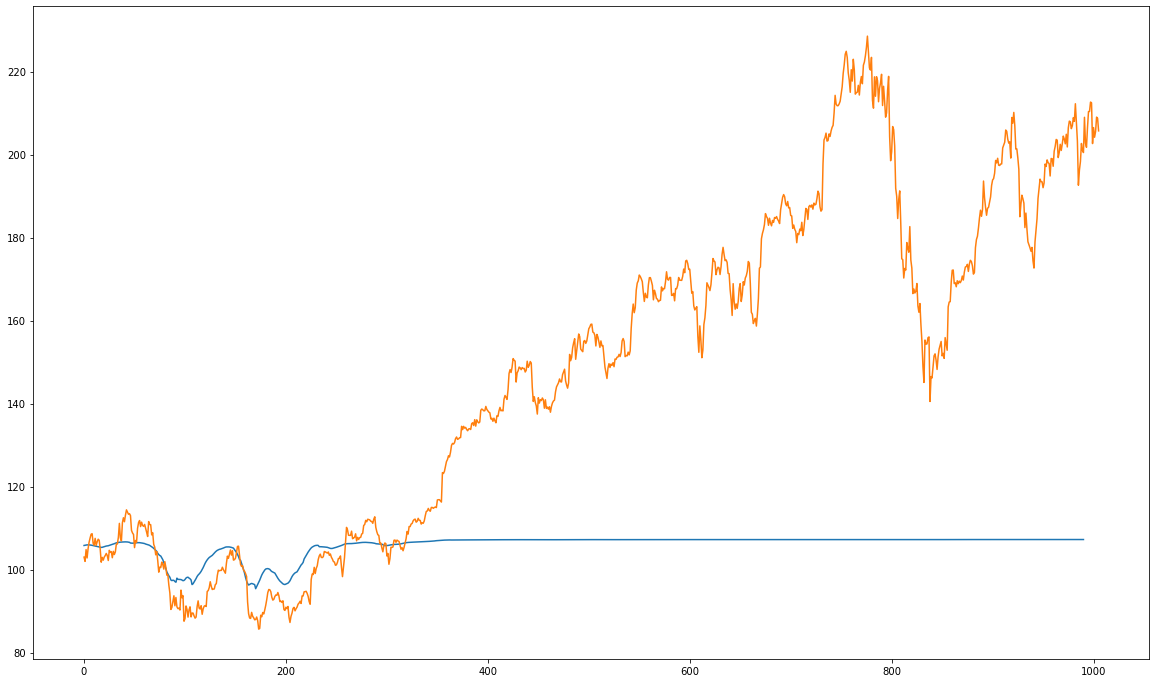

In [188]:
plt.figure(figsize=(20,12))

plt.plot(y_pred)
plt.plot(y_test);

### Now a Deeper Model

In [203]:
%cd .. 
%cd jupyter_notebooks/exploratory_modeling/weights

/Users/azel/github/Data-Science
/Users/azel/github/Data-Science/jupyter_notebooks/exploratory_modeling/weights


In [204]:
model = Sequential()
model.add(LSTM(100, activation='relu', 
               return_sequences=True, 
               input_shape=(train_data_generator.length, 
                            X_train.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True,
               activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

checkpointer = ModelCheckpoint(filepath='weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5', 
                               verbose=1, 
                               save_best_only=True)

callbacks_list = [checkpointer]

history_2 = model.fit_generator(train_data_generator, 
                              epochs = 50,
                              validation_data=test_data_generator,
                              verbose=1,
                              callbacks=callbacks_list)

Epoch 1/50
668/668 [==============================] - 27s 41ms/step - loss: 907.7363 - val_loss: 1431.0186

Epoch 00001: val_loss improved from inf to 1431.01863, saving model to weights-improvement-01-1431.02.hdf5
Epoch 2/50
668/668 [==============================] - 22s 32ms/step - loss: 84.6304 - val_loss: 1728.7548

Epoch 00002: val_loss did not improve from 1431.01863
Epoch 3/50
668/668 [==============================] - 22s 32ms/step - loss: 164.7938 - val_loss: 429.0272

Epoch 00003: val_loss improved from 1431.01863 to 429.02718, saving model to weights-improvement-03-429.03.hdf5
Epoch 4/50
668/668 [==============================] - 21s 32ms/step - loss: 87.6710 - val_loss: 111.3018

Epoch 00004: val_loss improved from 429.02718 to 111.30182, saving model to weights-improvement-04-111.30.hdf5
Epoch 5/50
668/668 [==============================] - 21s 32ms/step - loss: 62.8828 - val_loss: 383.6123

Epoch 00005: val_loss did not improve from 111.30182
Epoch 6/50
668/668 [=========

This should show clear overfitting.

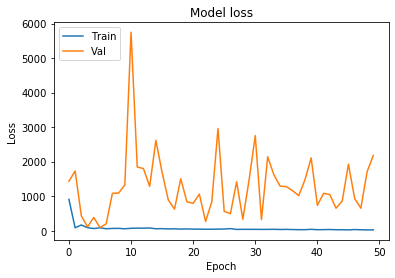

In [205]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


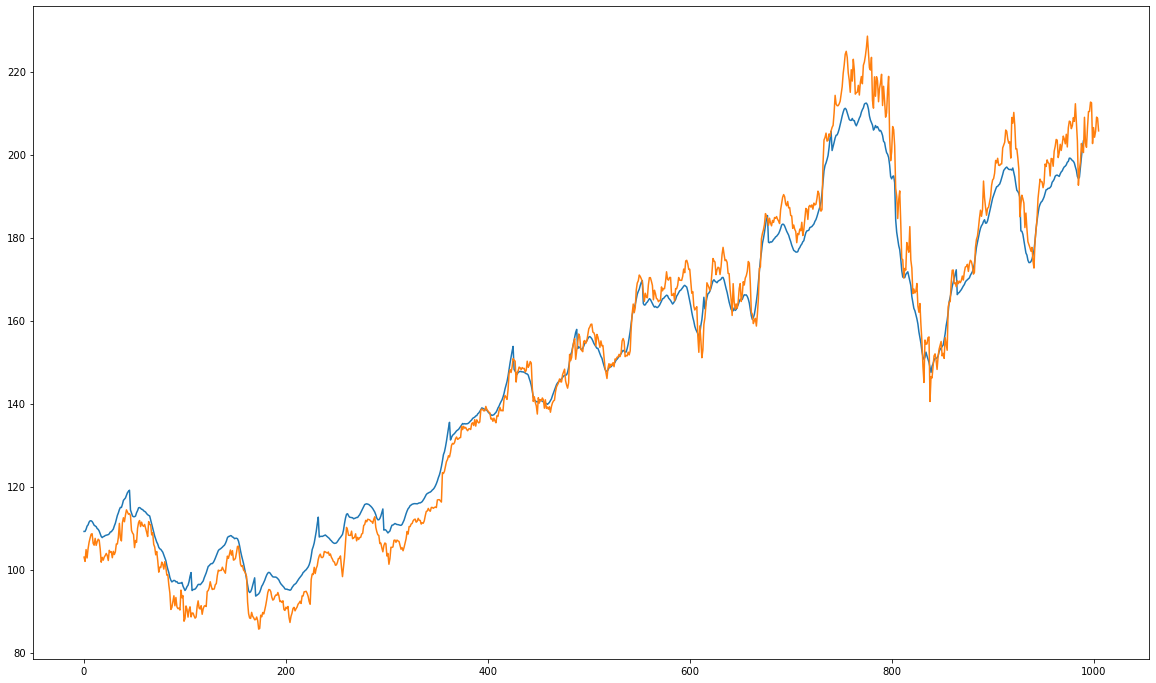

In [207]:
model.load_weights('weights-improvement-06-91.04.hdf5')

model.compile(optimizer='adam', loss='mse')

y_pred = model.predict_generator(test_data_generator)

plt.figure(figsize=(20,12))

plt.plot(y_pred)
plt.plot(y_test);